In [196]:
# If needed on a fresh env:
# !pip install torch torchvision pillow matplotlib

from pathlib import Path
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt

def load_image(path):
    return Image.open(path).convert("RGB")

def to_tensor(img):       # PIL -> [1,3,H,W] in [0,1]
    return T.ToTensor()(img).unsqueeze(0)

def to_pil(t):            # [1,3,H,W] -> PIL
    return T.ToPILImage()(t.squeeze(0).clamp(0,1))


In [197]:
def gaussian_blur(x, kernel_size=5, sigma=1.0):
    """
    Depthwise separable Gaussian blur for [B,C,H,W].
    """
    def gauss_1d(ks, s, device):
        ax = torch.arange(ks, device=device) - (ks - 1)/2.0
        g = torch.exp(-(ax**2) / (2*s*s))
        return g / g.sum()

    ks = kernel_size
    g = gauss_1d(ks, sigma, x.device)
    g_col = g.view(1,1,ks,1)
    g_row = g.view(1,1,1,ks)
    C = x.shape[1]
    x = F.conv2d(x, g_col.expand(C,1,ks,1), padding=(ks//2,0), groups=C)
    x = F.conv2d(x, g_row.expand(C,1,1,ks), padding=(0,ks//2), groups=C)
    return x

def unsharp_mask(x, amount=1.5, kernel_size=5, sigma=1.2):
    """
    Sharp = x + amount*(x - blur(x))
    """
    blurred = gaussian_blur(x, kernel_size, sigma)
    return (x + amount*(x - blurred)).clamp(0,1)

def sobel_edges(x_gray):
    """
    Sobel gradient magnitude, normalized to [0,1].
    x_gray: [B,1,H,W]
    """
    kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]],
                      dtype=torch.float32, device=x_gray.device).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]],
                      dtype=torch.float32, device=x_gray.device).view(1,1,3,3)
    gx = F.conv2d(x_gray, kx, padding=1)
    gy = F.conv2d(x_gray, ky, padding=1)
    mag = torch.sqrt(gx*gx + gy*gy + 1e-8)
    return mag / (mag.amax(dim=(2,3), keepdim=True) + 1e-8)

def dilate_binary(x, k=3, thresh=0.2):
    """
    Threshold + max-pool as a simple morphological dilation.
    """
    binary = (x > thresh).float()
    pad = k // 2
    return F.max_pool2d(binary, kernel_size=k, stride=1, padding=pad)


In [198]:
def process_portrait_minimal(
    pil_img,
    resize_hw=(768, 512),
    flip=None,                    # None | 'h' | 'v' | 'hv'
    unsharp_amount=1.5,
    unsharp_sigma=1.2,
    sobel_thresh=0.2,
    sobel_dilate_k=3,
):
    """
    Keeps only what you're actually using:
      - resize (+ optional flip)
      - unsharp masking (sharpen)
      - Sobel edges + dilation
      - overlay edges on the sharpened RGB
    """
    # Resize for consistent processing
    img_resized = T.Resize(resize_hw, interpolation=T.InterpolationMode.BILINEAR)(pil_img)

    # Flip (geometric)
    if flip in ("h", "hv"):
        img_resized = TF.hflip(img_resized)
    if flip in ("v", "hv"):
        img_resized = TF.vflip(img_resized)

    # To tensor
    x = to_tensor(img_resized)

    # Sharpen (neighborhood filtering)
    if unsharp_amount and unsharp_amount > 0:
        x = unsharp_mask(x, amount=unsharp_amount, sigma=unsharp_sigma)

    # Sobel edges (on grayscale), then simple dilation
    gray = (0.299*x[:,0:1] + 0.587*x[:,1:2] + 0.114*x[:,2:3]).clamp(0,1)
    edges = sobel_edges(gray)
    edges = dilate_binary(edges, k=sobel_dilate_k, thresh=sobel_thresh)


    return img_resized, edges.squeeze(0).squeeze(0).cpu().numpy()


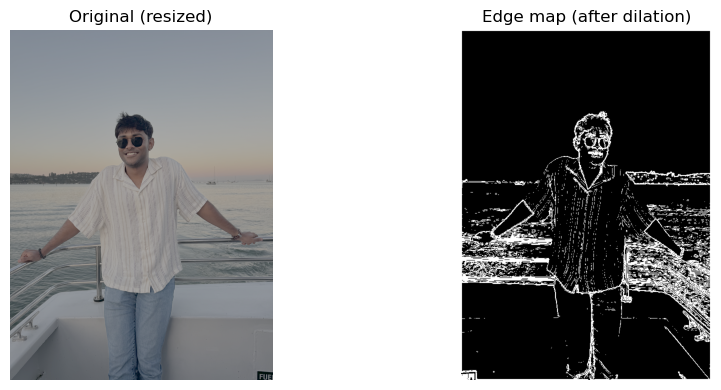

In [199]:

orig = orig = Image.open('/Users/hari/ASU Dropbox/Hari Varshan Dharmendra Mohan Prabu/Mac/Desktop/ASU  /CSE 507/Assignment 1 - Introduction/image.png')  


orig_resized, edge_map = process_portrait_minimal(
    orig,
    resize_hw=(700, 500),
    flip='h',                  # try 'h', 'v', or 'hv' if you want
    unsharp_amount=2,         # sharpen strength (your key knob)
    unsharp_sigma=1,          # how "wide" the blur is before adding detail back
    sobel_thresh=0.1,          # threshold for edges before dilation
    sobel_dilate_k=1,           # 3x3 dilation window
)

# Show original vs processed (+ edge map for debugging/figures)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(orig); plt.title("Original (resized)"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(edge_map, cmap="gray"); plt.title("Edge map (after dilation)"); plt.axis("off")
plt.tight_layout(); plt.show()


In [201]:
Image.fromarray((edge_map*255).astype("uint8")).save(f"processed.png")
